## This workflow demonstrates different types of clustering

Import various packages I'll need and the data

In [2]:
import numpy as np                                          # arrays and matrix math
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # for plotting
import geostatspy.GSLIB as GSLIB                            # for visualizing grid
from sklearn.cluster import KMeans                          # k-means clustering
import seaborn as sns                     # advanced statistical methods and plots
from scipy import stats                   # summary statistics
from sklearn.preprocessing import StandardScaler         # will use this to standardize
from sklearn.decomposition import PCA         
from sklearn.cluster import DBSCAN

View the data

In [3]:
data = pd.read_csv('unconv_MV_v5.csv')
data.head()


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


Take a subset of the data we want to cluster, and standardize it so the data all have mean of zero and variance of one

In [4]:
working_data = data[["Por", "Perm", "AI", "Brittle"]]
scaler = StandardScaler()                                   # instantiate the scaler 
sfeatures = scaler.fit_transform(working_data)              # standardize all the values extracted from the DataFrame 
data_st = pd.DataFrame(sfeatures, index=working_data.index, columns=working_data.columns) # copy the standardized values into the new DataFrame
data_st.describe()  

,Por,Perm,AI,Brittle
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,2.620126e-16,-5.662137e-17,3.985701e-16,1.824929e-16
std,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00
min,-2.848142e+00,-1.853701e+00,-2.986650e+00,-2.640962e+00
25%,-7.013606e-01,-6.997528e-01,-7.451372e-01,-7.383912e-01
50%,2.660490e-02,-1.712823e-01,-2.449306e-02,9.564649e-02
75%,8.136175e-01,5.540977e-01,6.652032e-01,7.166516e-01
max,2.887855e+00,3.208033e+00,2.937664e+00,2.566186e+00


Visualize the data prior to clustering

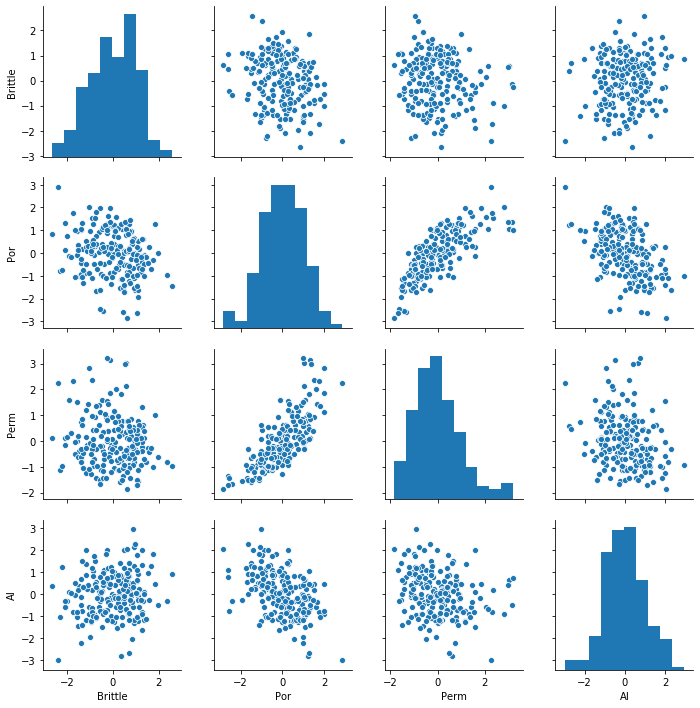

In [5]:
sns.pairplot(data_st,vars=['Brittle','Por','Perm','AI'],markers='o')

Initialize k-means clustering, with 4 clusters. This can (and should) be played around with to find the optimal number. This can also be set via prior/expert knowledge

In [6]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_st)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Add the labels to the DataFrame. This will allow us to see how the clusters performed

In [7]:
data_st["kmeans_cluster"] = kmeans.labels_

Visualize the k-means clusters to qualitatively asses how the clustering performed.

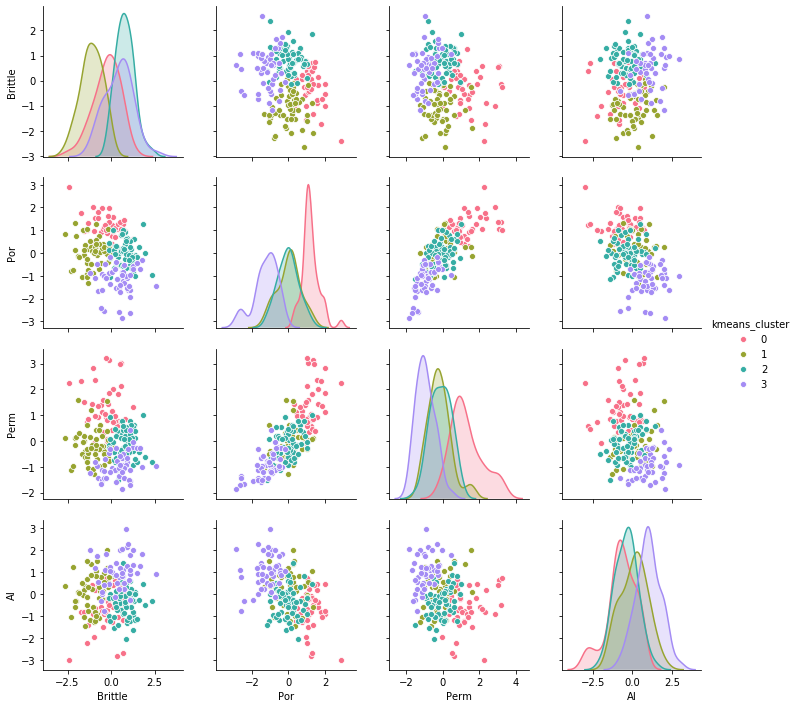

In [12]:
sns.pairplot(data_st,hue='kmeans_cluster',vars=['Brittle','Por','Perm','AI'],palette='husl')

We then will do principal component analysis to find the three principal components that best explain the variance of the data

I chose three because after this, variance explained was very low and was not worth keeping

In [14]:
data_st = data_st[["Brittle",'Por','Perm','AI']]
pca = PCA(n_components=3)
pca.fit(data_st)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
pca.components_


array([[-0.24839375,  0.64415578,  0.57906462, -0.43364506],
       [-0.95784843, -0.1300618 , -0.25576633,  0.01392445],
       [-0.12659867,  0.12678843,  0.45706933,  0.87119751]])

In [16]:
print('Variance explained by PC1 through PC3 =', np.round(pca.explained_variance_ratio_,3))
#pca.explained_variance_ratio_


Variance explained by PC1 through PC3 = [0.52  0.234 0.197]


In [17]:
pca.mean_

array([ 2.04281037e-16,  2.48689958e-16, -6.21724894e-17,  4.13002965e-16])

We then transform the data to the three principal components and add these to a new dataframe

In [18]:
pca_comps = pca.transform(data_st)
d = {'PC1':pca_comps[:,0],'PC2':pca_comps[:,1],'PC3':pca_comps[:,2]}
data_trans = pd.DataFrame(data=d)
data_trans.head()

,PC1,PC2,PC3
0,-1.562137,-1.926327,-1.056678
1,-0.993560,0.374760,0.081161
2,-2.027516,-1.348320,0.880422
3,1.800615,0.083350,0.307964
4,1.123942,2.388425,0.831171


Now we visualize the PCs -- it looks very scattered

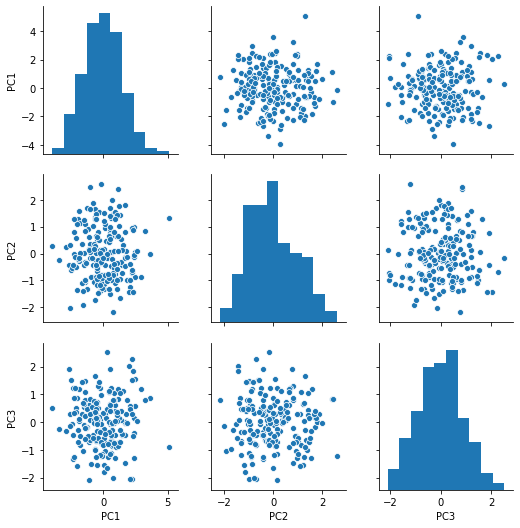

In [19]:
sns.pairplot(data_trans,vars=['PC1','PC2','PC3'])

I'm now going to transform the data back to the original features -- this is necessary because PC1, PC2, and PC3 are not easy to translate to anything else

In [20]:
data_untrans = pca.inverse_transform(data_trans)   #untransforming the data

data_untrans = pd.DataFrame(data_untrans)
data_untrans.columns = ['Brittle','Por','Perm','AI'] # rename columns of the 
data_untrans.head()

,Brittle,Por,Perm,AI
0,2.366928,-0.889693,-0.894864,-0.269985
1,-0.122444,-0.678459,-0.634090,0.506778
2,1.683648,-1.019044,-0.426794,1.627469
3,-0.566085,1.188082,1.162115,-0.511369
4,-2.672154,0.518734,0.419859,0.269980


Here I'm just checking the data again to make sure it looks like it should

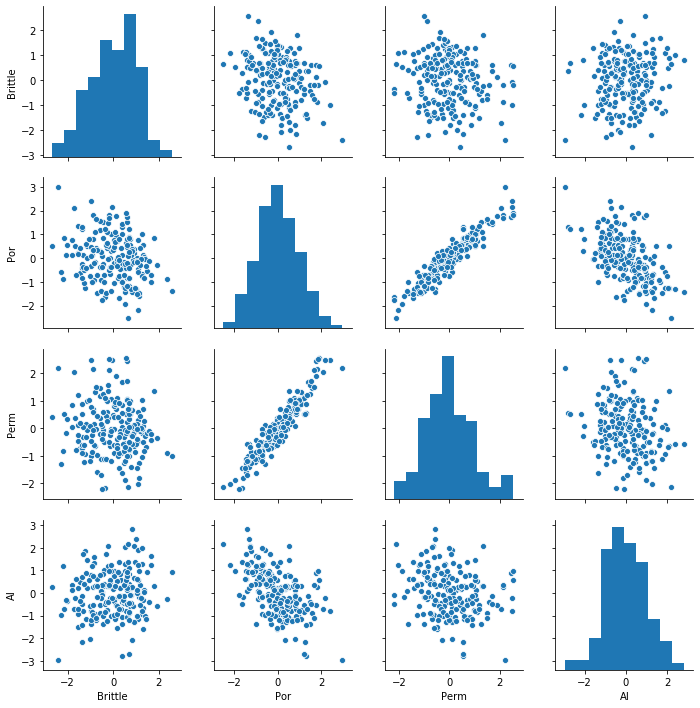

In [21]:
sns.pairplot(data_untrans, vars=['Brittle','Por','Perm','AI'])


Now I'm going to use DBCAN to transform the data -- Density-based spatial clustering of applications with noise

This is an alternate clustering method

Eps is defined as "The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster."

In [43]:
db = DBSCAN(eps=0.7)
db.fit(data_st)


DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [44]:
db.labels_

array([-1,  0, -1,  0, -1,  0,  0,  0,  0, -1,  0, -1, -1,  0, -1,  0, -1,
        1,  0,  0,  0, -1, -1, -1, -1, -1,  0, -1, -1,  0,  0,  1,  0,  0,
       -1,  2,  0, -1,  0,  0, -1,  0, -1,  2,  0,  1, -1,  2,  0, -1,  0,
       -1,  0, -1, -1,  0,  2, -1,  1,  0,  0,  1,  0,  0,  0, -1,  1,  0,
        0,  0,  0,  0, -1,  1,  0, -1, -1, -1, -1,  0,  0,  0,  0, -1, -1,
        0,  0,  0, -1, -1,  0, -1, -1, -1, -1,  0,  0, -1, -1, -1,  0,  0,
        0, -1, -1,  0,  0,  1, -1,  0, -1, -1,  0, -1, -1,  0, -1,  0, -1,
        0,  0, -1, -1,  0, -1,  0, -1,  0,  0, -1, -1,  1,  0, -1, -1, -1,
       -1,  0, -1, -1, -1,  0, -1, -1,  0,  0,  0,  0,  0, -1,  2,  0,  0,
       -1, -1,  0,  0,  0,  0, -1,  0, -1, -1, -1, -1, -1, -1,  2, -1, -1,
       -1,  0, -1, -1,  1,  0, -1,  2,  0, -1,  0,  0,  0, -1, -1, -1,  1,
       -1,  0,  1,  0, -1, -1, -1,  0,  0, -1,  0,  0, -1])

In [45]:
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print('Estimated number of clusters: %d' % n_clusters_)


Estimated number of clusters: 3


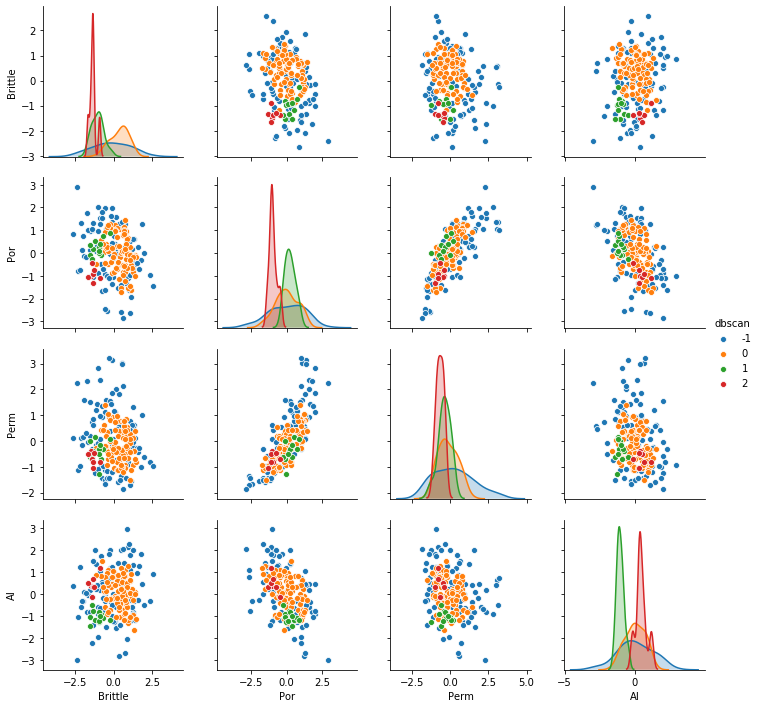

In [46]:
data_st['dbscan'] = db.labels_
sns.pairplot(data_st, hue='dbscan',vars=['Brittle','Por','Perm','AI'])

-1 is an outlier, then 0, 1, and 2 are the clusters. This is highly sensitive to eps and the clusters appear much less clear spatially than k-means clustering

DBSCAN goes through and measures nearest neighbors based on a prescribed distance, then either adds the point to that cluster, creates a new cluster, or assigns the point as an
outlier. Compared to kmeans, it’s useful because it does not actually use outliers, where this could skew kmeans output, and it predicts the number of clusters that it thinks fit the data (based on the prescribed distance and number of data points required for a cluster). DBSCAN also allows the clusters to be different sizes. It’s highly sensitive to the prescribed distance, and after testing many values of epsilon on the standardized data, it seems that 3 clusters may actually fit the data best without throwing out a majority of the data as outliers.